In [25]:
import tensorflow as tf
from datetime import datetime
print(tf.__version__)
print("Num of GPUs available: ", len(tf.test.gpu_device_name()))
print("Started at ", datetime.now())

2.9.1
Num of GPUs available:  0
Started at  2022-09-11 21:12:05.791300


2022-09-11 21:12:05.790894: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-11 21:12:05.791175: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [26]:
!pip install opencv-python
!pip install scipy

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

In [29]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam

In [30]:
# download dataset
# Path
dataset_path = "../../dataset/monkeys/"
ipfs_monkey_uri="https://calibration-ipfs.filswan.com/ipfs/QmQhckZqk2rPyeyekt6KMTAR4TEKAs1xi8R3DTCgFqfQgs"
isdir = os.path.isdir(dataset_path)
if isdir:
    print("Dataset Monkey found.")

Dataset Monkey found.


In [31]:
# load training and testing sets
train_dataset_path = dataset_path + "training/training/"
test_dataset_path = dataset_path + "validation/validation/"
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train = datagen.flow_from_directory(train_dataset_path, target_size=(160, 160), batch_size=32)
test = datagen.flow_from_directory(test_dataset_path, target_size=(160, 160), batch_size=32, shuffle=False)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [32]:
# read labels
file = pd.read_csv(dataset_path +'monkey_labels.txt', sep='[\s,]{2,20}', engine='python')
labels = file['Common Name']
labels

0               mantled_howler
1                 patas_monkey
2                  bald_uakari
3             japanese_macaque
4               pygmy_marmoset
5        white_headed_capuchin
6             silvery_marmoset
7       common_squirrel_monkey
8    black_headed_night_monkey
9               nilgiri_langur
Name: Common Name, dtype: object

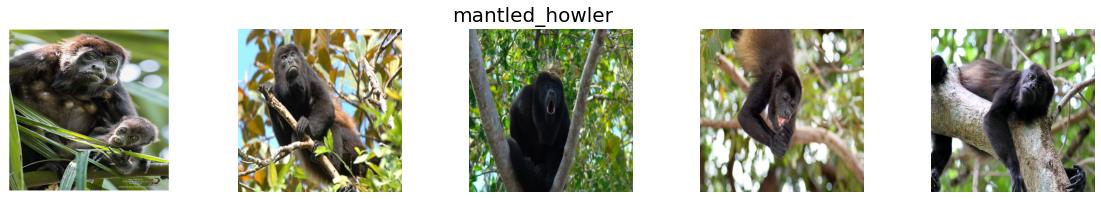

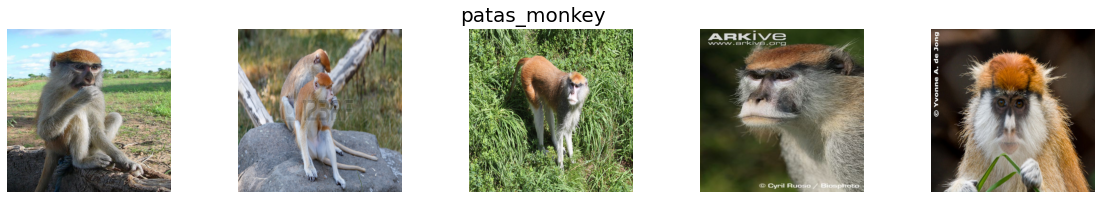

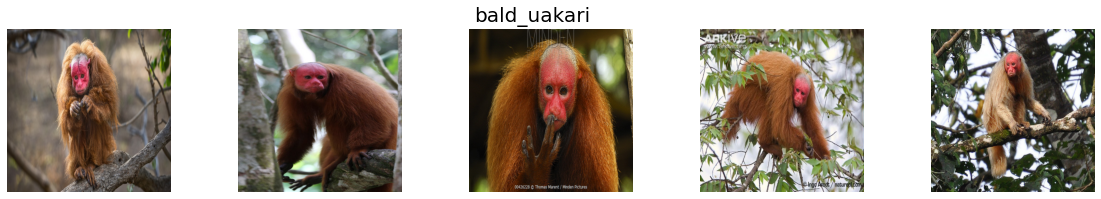

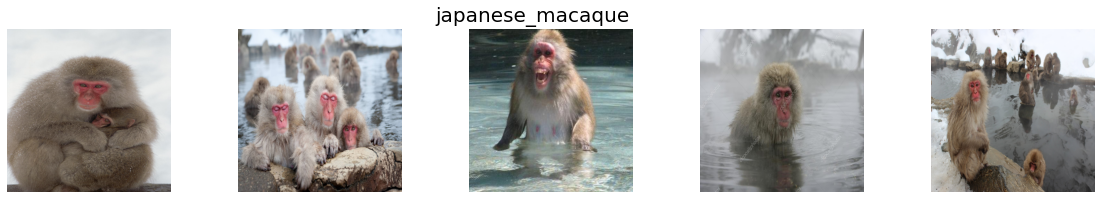

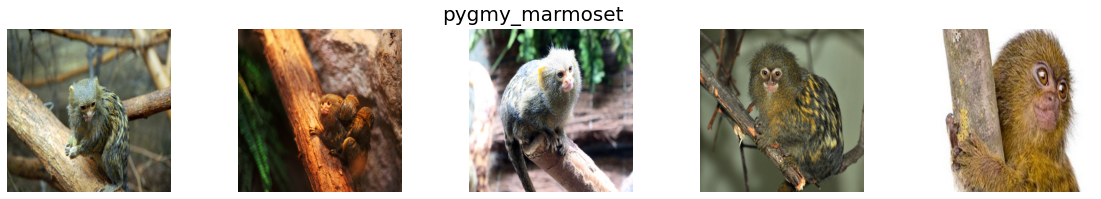

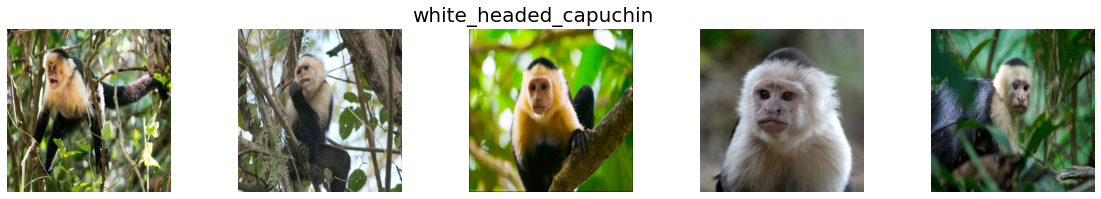

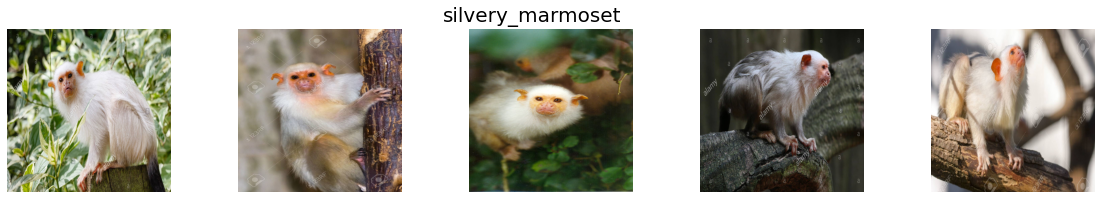

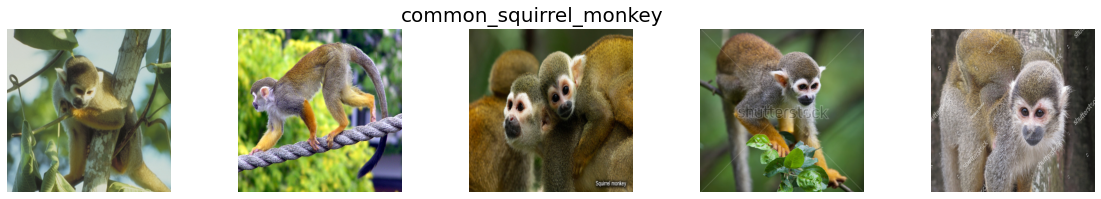

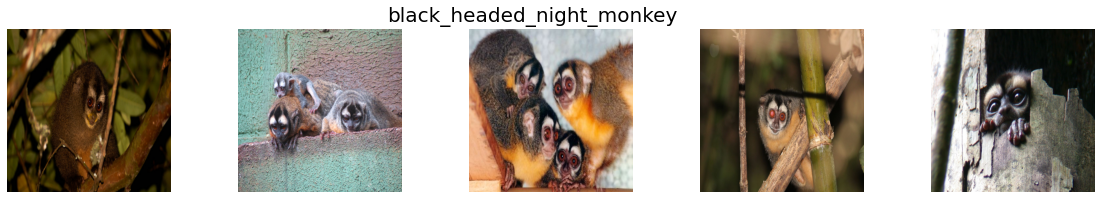

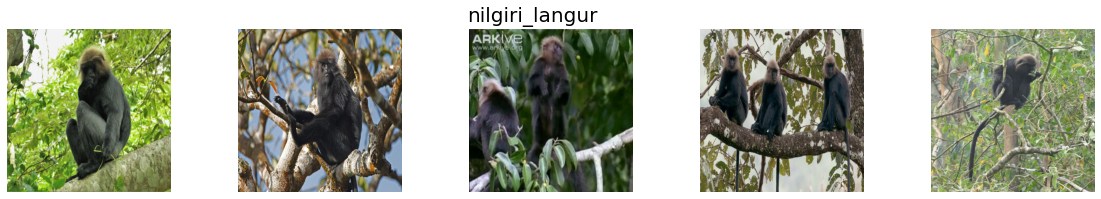

In [33]:
# display images of each category
folders = os.listdir(train_dataset_path)
folders.sort()
for i, folder in enumerate(folders):
    path = train_dataset_path + folder
    imgs = os.listdir(path)
    plt.figure(figsize=(20,3))
    for j in range(5):
        img = cv2.cvtColor(cv2.imread(path + '/' + imgs[j]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (640, 640))
        plt.subplot(1,5,j+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(labels[i], fontsize="20")
    plt.show()
    print("\n\n")

In [34]:
IMG_SHAPE = (160, 160, 3)
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

2022-09-11 21:12:11.016277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-11 21:12:11.016561: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [35]:
base_model.trainable = False
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(514, activation='relu')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 514)               526850    
                                                             

In [36]:
model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/home/ccao/miniconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [37]:
history = model.fit(train, epochs=5)

Epoch 1/5
35/35 [==============================] - 18s 463ms/step - loss: 0.9759 - accuracy: 0.7149
Epoch 2/5
35/35 [==============================] - 17s 471ms/step - loss: 0.1638 - accuracy: 0.9599
Epoch 3/5
35/35 [==============================] - 17s 489ms/step - loss: 0.0769 - accuracy: 0.9882
Epoch 4/5
35/35 [==============================] - 17s 484ms/step - loss: 0.0474 - accuracy: 0.9900
Epoch 5/5
35/35 [==============================] - 18s 494ms/step - loss: 0.0281 - accuracy: 0.9982


In [38]:
acc = history.history['acc']
loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

KeyError: 'acc'

In [ ]:
prediction = model.predict_generator(test)
predicted_classes = np.argmax(prediction, axis=1)
test_acc = np.mean(predicted_classes == test.classes)
print("Test accuracy: {:.6f}".format(test_acc))

In [ ]:
show_test = ImageDataGenerator().flow_from_directory(test_dataset_path, target_size=(160, 160), batch_size=test.samples, shuffle=False)
x, _ = show_test.next()
classes = test.classes

In [ ]:
# generate random indices
random_indices = np.random.randint(0, test.samples, size=28)

In [ ]:
# prediction
plt.figure(figsize=(20,30))
for i, idx in enumerate(random_indices):
    img = np.uint8(x[idx])
    plt.subplot(7,4,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("class: " + labels[classes[idx]] + "\npredicted: " + labels[predicted_classes[idx]])
plt.show()

In [ ]:
print("Completed at ", datetime.now())
